<font color='darkblue'>

# Analysis of UK Weather Observations: 11th of August, 2024

</font>

<font color='darkblue'>
    
### This Jupyter Notebook features an analysis of the quality of surface observations, including the identification of missing data and outliers, the implementation of unit tests for data quality assurance, and solutions for imputing missing values. The data comprises hourly weather observations downloaded from the Met Office on 11 August 2024 [UK hourly site-specific observations](https://www.metoffice.gov.uk/services/data/datapoint/uk-hourly-site-specific-observations).
</font>

<font color='darkblue'>
    
# <u>Contents</u>
## 1. __Data Loading and Processing__
 - ### 1.1. Importing and processing weather observations data from a DataPoint json file
 - ### 1.2. Exporting processed data to a csv file
   
## 2. __Data Exploration__
 - ### 2.1. Statistical summary, ranges and unique values
 - ### 2.2. Frequency distributions of numeric variables
 - ### 2.3. Box plots for numeric variables
 - ### 2.4. Scatter plots: elevation vs. other numeric variables
   
## 3. __Identifying Missing Values and Outliers__
  - ### 3.1. Unit Testing for acceptable ranges
  - ### 3.2. Identifying missing(null) values
  - ### 3.3. Outlier detection using Interquartile Range (IQR)
  - ### 3.4. Analyzing missing values and outliers by location
    
## 4. __Imputing missing data__
- ### 4.1. Imputing missing numeric data using linear interpolation and nearest neighbor averaging
    - #### 4.1.1. Visualising UK weather locations  with a Folium map
    - #### 4.1.2. Imputing missing values for numeric variables
- ### 4.2. Visualizing imputed data for numeric variables
- ### 4.3. Imputing missing Weather Type (Categorical Data) using the XGBoost model
</font>

In [21]:
# Load the libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import itertools
from geopy.distance import geodesic
from geopy.geocoders import GoogleV3
from IPython.display import IFrame
import folium

<font color='darkblue'>
    
## 1. __Data Loading and Processing__
 - ### 1.1. Importing and processing weather observations data from a DataPoint json file
 - ### 1.2. Exporting processed data to a csv file
   
</font>

<font color='darkblue'>

###  1.1. Importing and processing weather observations data from a DataPoint json file
</font>    

In [48]:

# Load the JSON file
file_path = "C:\\Users\\maria\\Jupyter_notebooks\\Met_folder\\all_loc_observations.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract relevant information
locations = data['SiteRep']['DV']['Location']

# Initialize lists to store data for DataFrames
data_df1 = []
data_df2 = []

# Iterate through locations and periods to extract data
for location in locations:
    loc_info = {
        'i': location['i'],
        'lat': location['lat'],
        'lon': location ['lon'],
        'town': location['name'],
        'country': location['country'],
        'elevation': location['elevation']
    }
    
    for period in location['Period']:
        date = period['value']
        for rep in period['Rep']:
            row = loc_info.copy()
            row['wind gust'] = rep.get('G', np.nan)
            row['temperature'] = rep.get('T', np.nan)
            row['visibility'] = rep.get('V', np.nan)
            row['wind direction'] = rep.get('D', np.nan)
            row['wind speed'] = rep.get('S', np.nan)
            row['weather type'] = rep.get('W', np.nan)
            row['pressure'] = rep.get('P', np.nan)
            row['pressure tendency'] = rep.get('Pt', np.nan)
            row['dew point'] = rep.get('Dp', np.nan)
            row['screen relative humidity'] = rep.get('H', np.nan)
            if date == "2024-08-10Z":
                row['date'] = "2024-08-10Z"
                data_df1.append(row)
            elif date == "2024-08-11Z":
                row['date'] = "2024-08-11Z"
                data_df2.append(row)

# Create DataFrames
columns = [
    'i', 'lat', 'lon','town', 'country', 'elevation', 'date', 
    'wind gust', 'temperature', 'visibility', 'wind direction', 
    'wind speed', 'weather type', 'pressure', 'pressure tendency', 
    'dew point', 'screen relative humidity'
]

df1 = pd.DataFrame(data_df1, columns=columns)
df2 = pd.DataFrame(data_df2, columns=columns)

# Convert specified columns to numeric
numeric_columns = [ 'lat', 'lon',
    'wind gust', 'temperature', 'visibility', 
    'wind speed', 'pressure',  
    'dew point', 'screen relative humidity', 'elevation'
]

df1[numeric_columns] = df1[numeric_columns].apply(pd.to_numeric, errors='coerce')
df2[numeric_columns] = df2[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Convert 'date' column to datetime format
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%dZ')
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%dZ')


In [46]:
# Display DataFrames
print("DataFrame for 2024-08-10Z:")

df1.info()

DataFrame for 2024-08-10Z:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   i                         1340 non-null   object        
 1   lat                       1340 non-null   float64       
 2   lon                       1340 non-null   float64       
 3   town                      1340 non-null   object        
 4   country                   1340 non-null   object        
 5   elevation                 1340 non-null   float64       
 6   date                      1340 non-null   datetime64[ns]
 7   wind gust                 1230 non-null   float64       
 8   temperature               1335 non-null   float64       
 9   visibility                1175 non-null   float64       
 10  wind direction            1280 non-null   object        
 11  wind speed                1280 non-null   float64      

In [26]:
# Display DataFrames
print("DataFrame for 2024-08-11Z:")

df2.info()

DataFrame for 2024-08-11Z:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   i                         2000 non-null   object        
 1   town                      2000 non-null   object        
 2   country                   2000 non-null   object        
 3   elevation                 2000 non-null   float64       
 4   date                      2000 non-null   datetime64[ns]
 5   wind gust                 1835 non-null   float64       
 6   temperature               1992 non-null   float64       
 7   visibility                1750 non-null   float64       
 8   wind direction            1910 non-null   object        
 9   wind speed                1910 non-null   float64       
 10  weather type              1806 non-null   object        
 11  pressure                  1872 non-null   float64      

In [230]:
df2.describe()

,elevation,wind gust,temperature,visibility,wind speed,pressure,dew point,screen relative humidity
count,2000.000000,1835.000000,1992.000000,1750.000000,1910.000000,1872.000000,1992.000000,1992.000000
mean,117.580000,12.048501,16.210291,29538.920000,7.096859,1020.038996,12.555773,80.741365
std,182.340431,6.447535,4.727899,17579.853621,4.618221,1.797045,3.301876,15.756869
min,2.000000,0.000000,3.800000,90.000000,0.000000,1010.000000,2.700000,36.200000
25%,21.000000,7.000000,12.400000,17000.000000,3.000000,1019.000000,10.200000,69.300000
50%,68.000000,11.000000,16.200000,29000.000000,7.000000,1021.000000,12.000000,84.850000
75%,133.000000,16.000000,19.300000,40000.000000,10.000000,1021.000000,15.300000,94.200000
max,1245.000000,51.000000,29.200000,75000.000000,38.000000,1023.000000,19.500000,100.000000


In [57]:
# There are 10 observations per town in df1

df1.groupby(['i']).size()

i
3002     10
3005     10
3008     10
3017     10
3023     10
         ..
3980     10
99057    10
99060    10
99081    10
99142    10
Length: 134, dtype: int64

In [260]:
# There are 15 observations per town in df2
df2.groupby(['i']).size()

i
3002     15
3005     15
3008     15
3017     15
3023     15
         ..
3980     15
99057    15
99060    15
99081    15
99142    15
Length: 134, dtype: int64

In [61]:
# How many nans in columns
df1.isna().sum()

i                             0
town                          0
country                       0
elevation                     0
date                          0
wind gust                   110
temperature                   5
visibility                  165
wind direction               60
wind speed                   60
weather type                140
pressure                     85
pressure tendency            85
dew point                     5
screen relative humidity      5
dtype: int64

In [197]:
df2.isna().sum()

i                             0
town                          0
country                       0
elevation                     0
date                          0
wind gust                   165
temperature                   8
visibility                  250
wind direction               90
wind speed                   90
weather type                194
pressure                    128
pressure tendency           128
dew point                     8
screen relative humidity      8
dtype: int64

<font color='darkblue'>

### 1.2. Exporting data to a csv file
   
</font>

In [196]:
# Write to a csv file

df1.to_csv('df1_met_data.csv_2024-08-10Z', sep='\t', encoding='utf-8', index=False, header=True)
df2.to_csv('df2_met_data_2024-08-11Z.csv', sep='\t', encoding='utf-8', index=False, header=True)

<font color='darkblue'>
    
## 2. __Data Exploration__
 - ### 2.1. Statistical summary, ranges and unique values
 - ### 2.2. Frequency distributions of numeric variables
 - ### 2.3. Box plots for numeric variables
 - ### 2.4. Scatter plots: elevation vs. other numeric variables   
</font>

<font color='darkblue'>

### 2.1. Statistical Summary, ranges and unique values
</font>

In [4]:
# Function to print statistical summary, ranges, and unique values
def print_ranges_and_uniques(df):
    print("\nStatistical Summary:")
    print(df.describe())

    numeric_columns = [
        'wind gust', 'wind speed','temperature', 'pressure','visibility', 
        'dew point', 'screen relative humidity', 'elevation'
    ]

    non_numeric_columns = ['town','country','weather type', 'wind direction', 'pressure tendency']
    
    # Convert numeric columns to numeric, coerce errors to NaN
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    print("\nNumeric Columns Ranges:")
    for col in numeric_columns:
        if df[col].dtype != 'object':
            print(f"{col}: Min = {df[col].min()}, Max = {df[col].max()}")
            
    print(f"\nNumber of unique towns(locations): {df.town.nunique()}")        
    
    print("\nNon-Numeric Columns Unique Values:")
    for col in non_numeric_columns:
        print(f"\n{col}: {df[col].unique()}")

# Example usage with df2
print_ranges_and_uniques(df2)



Statistical Summary:
               lat          lon    elevation    wind gust  temperature  \
count  2000.000000  2000.000000  2000.000000  1835.000000  1992.000000   
mean     53.703622    -2.898477   117.580000    12.048501    16.210291   
std       2.477450     2.298770   182.340431     6.447535     4.727899   
min      49.207900   -10.250000     2.000000     0.000000     3.800000   
25%      51.708000    -4.203750    21.000000     7.000000    12.400000   
50%      53.175000    -2.800000    68.000000    11.000000    16.200000   
75%      55.311000    -1.250000   133.000000    16.000000    19.300000   
max      60.749000     1.348000  1245.000000    51.000000    29.200000   

         visibility   wind speed     pressure    dew point  \
count   1750.000000  1910.000000  1872.000000  1992.000000   
mean   29538.920000     7.096859  1020.038996    12.555773   
std    17579.853621     4.618221     1.797045     3.301876   
min       90.000000     0.000000  1010.000000     2.700000   
2

<font color='darkblue'>
    
### 2.2. Visualising frequency distributions of numeric variables

</font>

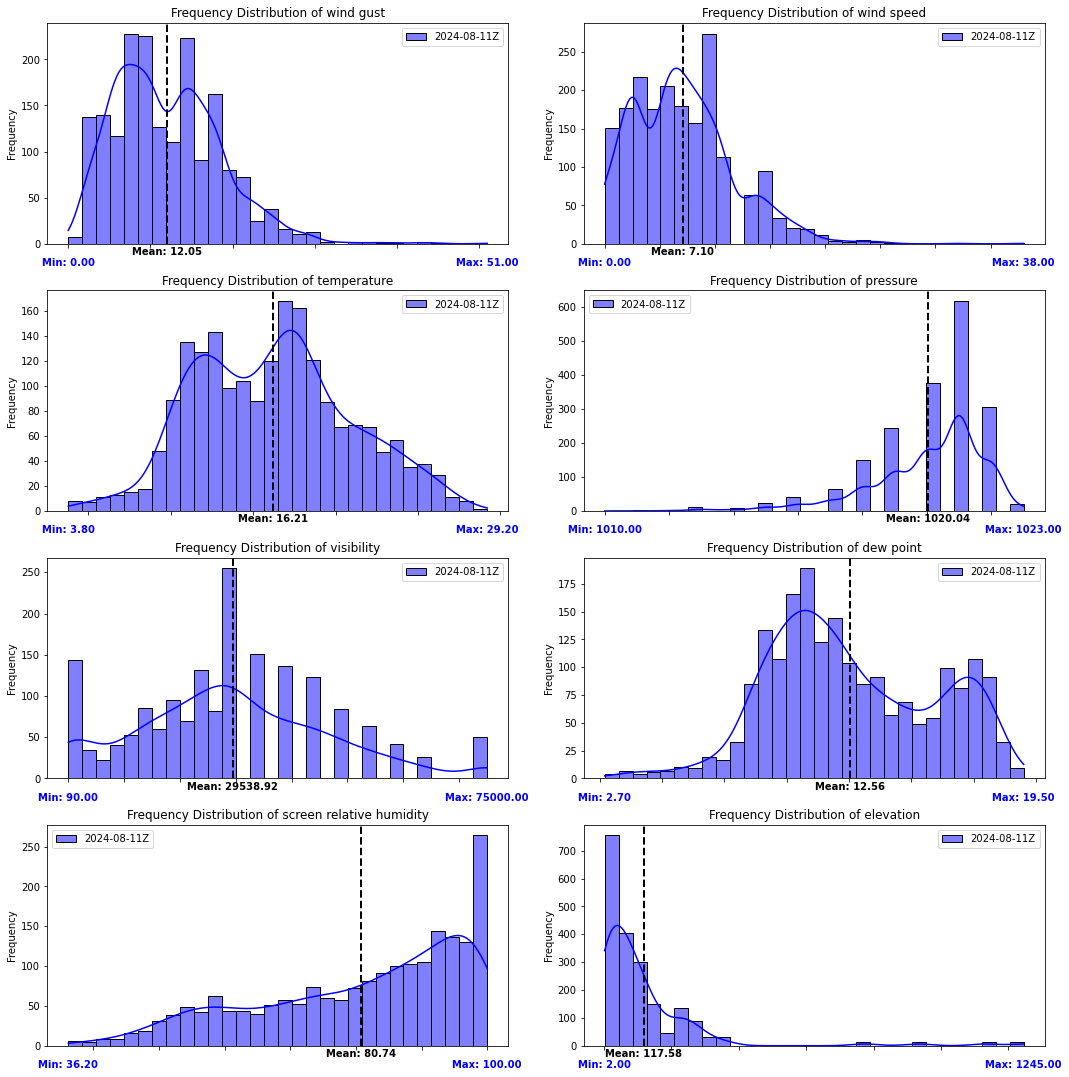

In [233]:
# Set up the grid for plotting with 4 rows and 2 columns (4x2 grid)

numeric_columns = [
        'wind gust', 'wind speed','temperature', 'pressure','visibility', 
        'dew point', 'screen relative humidity', 'elevation'
    ]
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the grid for easy iteration

for i, col in enumerate(numeric_columns):
    # Plot histogram with KDE for each numeric column
    sns.histplot(df2[col].dropna(), kde=True, bins=30, color='blue', label='2024-08-11Z', ax=axes[i])
    
    # Calculate and draw a vertical line at the mean
    mean_value = df2[col].mean()
    min_value = df2[col].min()
    max_value = df2[col].max()
    
    axes[i].axvline(mean_value, color='black', linewidth=2, linestyle='--')
    
    # Display the mean value below the X-axis
    axes[i].text(mean_value, axes[i].get_ylim()[0] - axes[i].get_ylim()[1] * 0.05,
                f'Mean: {mean_value:.2f}', color='black', ha='center', fontweight='bold')
    
    # Display the minimum value a bit below the X-axis
    axes[i].text(min_value, axes[i].get_ylim()[0] - axes[i].get_ylim()[1] * 0.1,
                f'Min: {min_value:.2f}', color='blue', ha='center', fontweight='bold')
    
    # Display the maximum value a bit below the X-axis
    axes[i].text(max_value, axes[i].get_ylim()[0] - axes[i].get_ylim()[1] * 0.1,
                f'Max: {max_value:.2f}', color='blue', ha='center', fontweight='bold')
    
    # Set the title and labels
    axes[i].set_title(f'Frequency Distribution of {col}')
    axes[i].set_xlabel('')  # Remove X-axis label
    axes[i].set_xticklabels([])  # Remove X-axis tick labels
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Hide any unused subplots (in this case, there should be none, since we have exactly 8 plots)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

<font color='darkblue'>
    
#### The frequency disributions for *Temperature, Visibility* and *Dew Point* appear normal. 
#### The frequency disributions for *Wind Gust, Wind Speed* and *Elevation* are right-skewed, while Pressure  and Screen Relative  Humidity are left-skewed. For *Wind Gust* and *Wind Speed* we can adjust the upper bound by using a higher Q3 multiplier, such as Q3+3 ×IQR. For *Pressure* and *Relative Humidity*, we can decrease the lower bound multiplier to  Q1−3.5×IQR and Q1−2.5×IQR, respectively.

#### Log transformation is another effective method for detecting outliers in skewed distributions. It works well for right-skewed data (with larger values) but is not suitable for left-skewered data (with smaller values).
</font>

<font color='darkblue'>
    
### 2.3. Visualising box plots of numeric variables
</font>

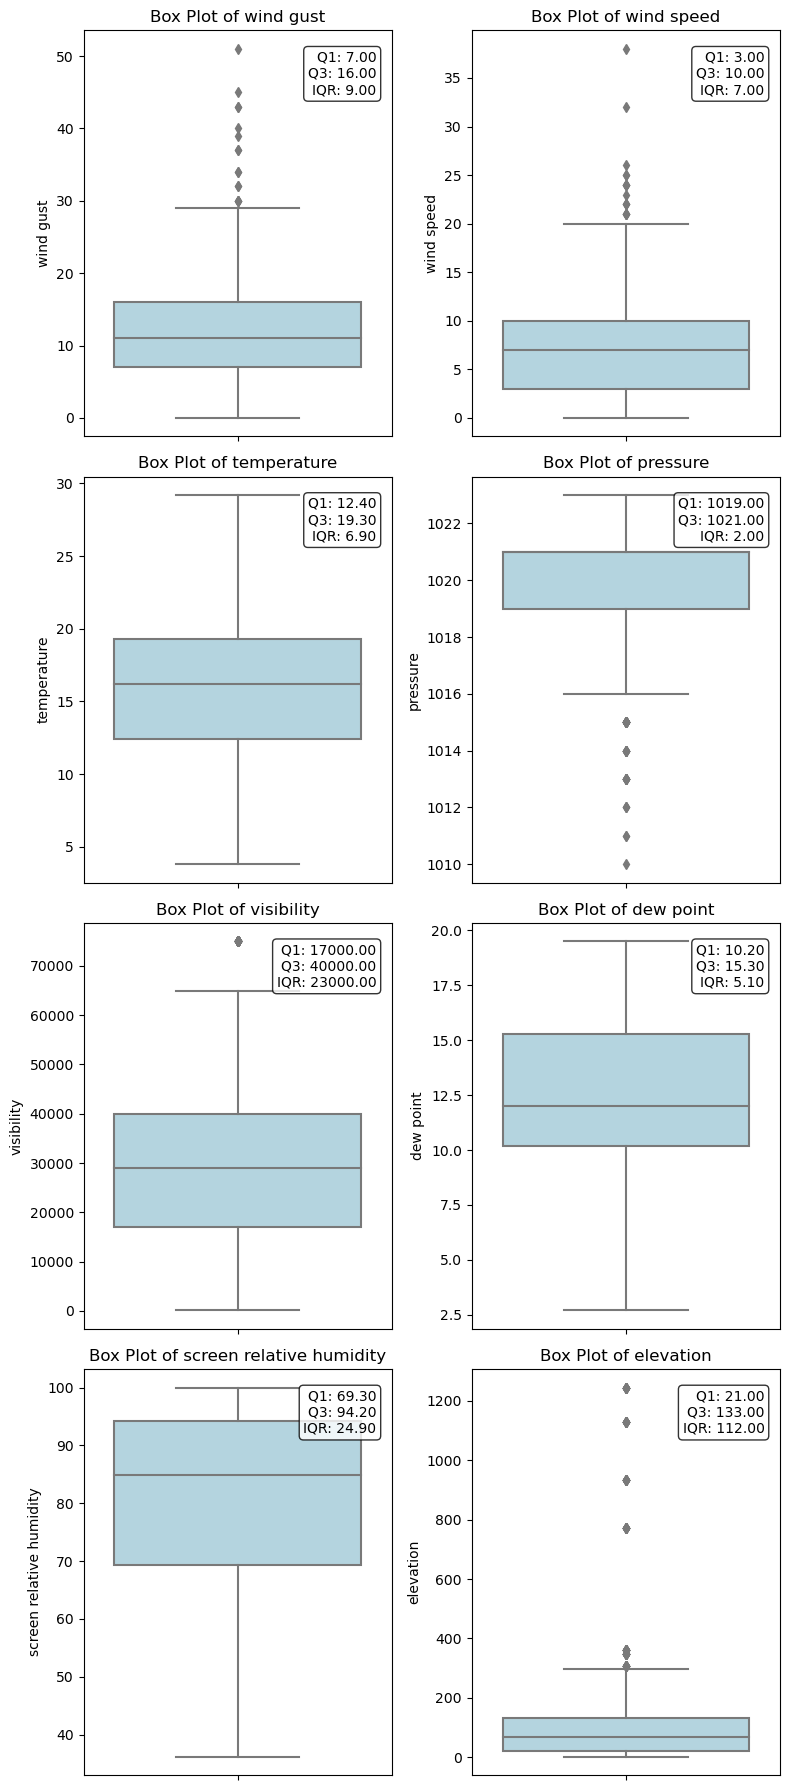

In [256]:
# Set up the grid for plotting with 4 rows and 2 columns (4x2 grid)
fig, axes = plt.subplots(4, 2, figsize=(8, 18))
axes = axes.flatten()  # Flatten the grid for easy iteration

numeric_columns = [
        'wind gust', 'wind speed','temperature', 'pressure','visibility', 
        'dew point', 'screen relative humidity', 'elevation'
    ]
for i, col in enumerate(numeric_columns):
    # Plot box plot for each numeric column
    sns.boxplot(data=df2, y=col, ax=axes[i], color='lightblue')
    
    # Set title and labels
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel(col)
    axes[i].set_xlabel('')  # Remove X-axis label

    # Calculate Q1, Q3, and IQR
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1

    # Create a text box in the top right corner with Q1, Q3, and IQR
    textstr = f'Q1: {Q1:.2f}\nQ3: {Q3:.2f}\nIQR: {IQR:.2f}'
    
    # Add text box to the plot
    axes[i].text(
        0.95, 0.95, textstr, 
        transform=axes[i].transAxes,  # Use Axes coordinates
        fontsize=10,
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.8)
    )

# Adjust the layout
plt.tight_layout()
plt.show()


<font color='darkblue'>

### 2.4. Scatter plots: elevation vs. other numeric variables
</font>

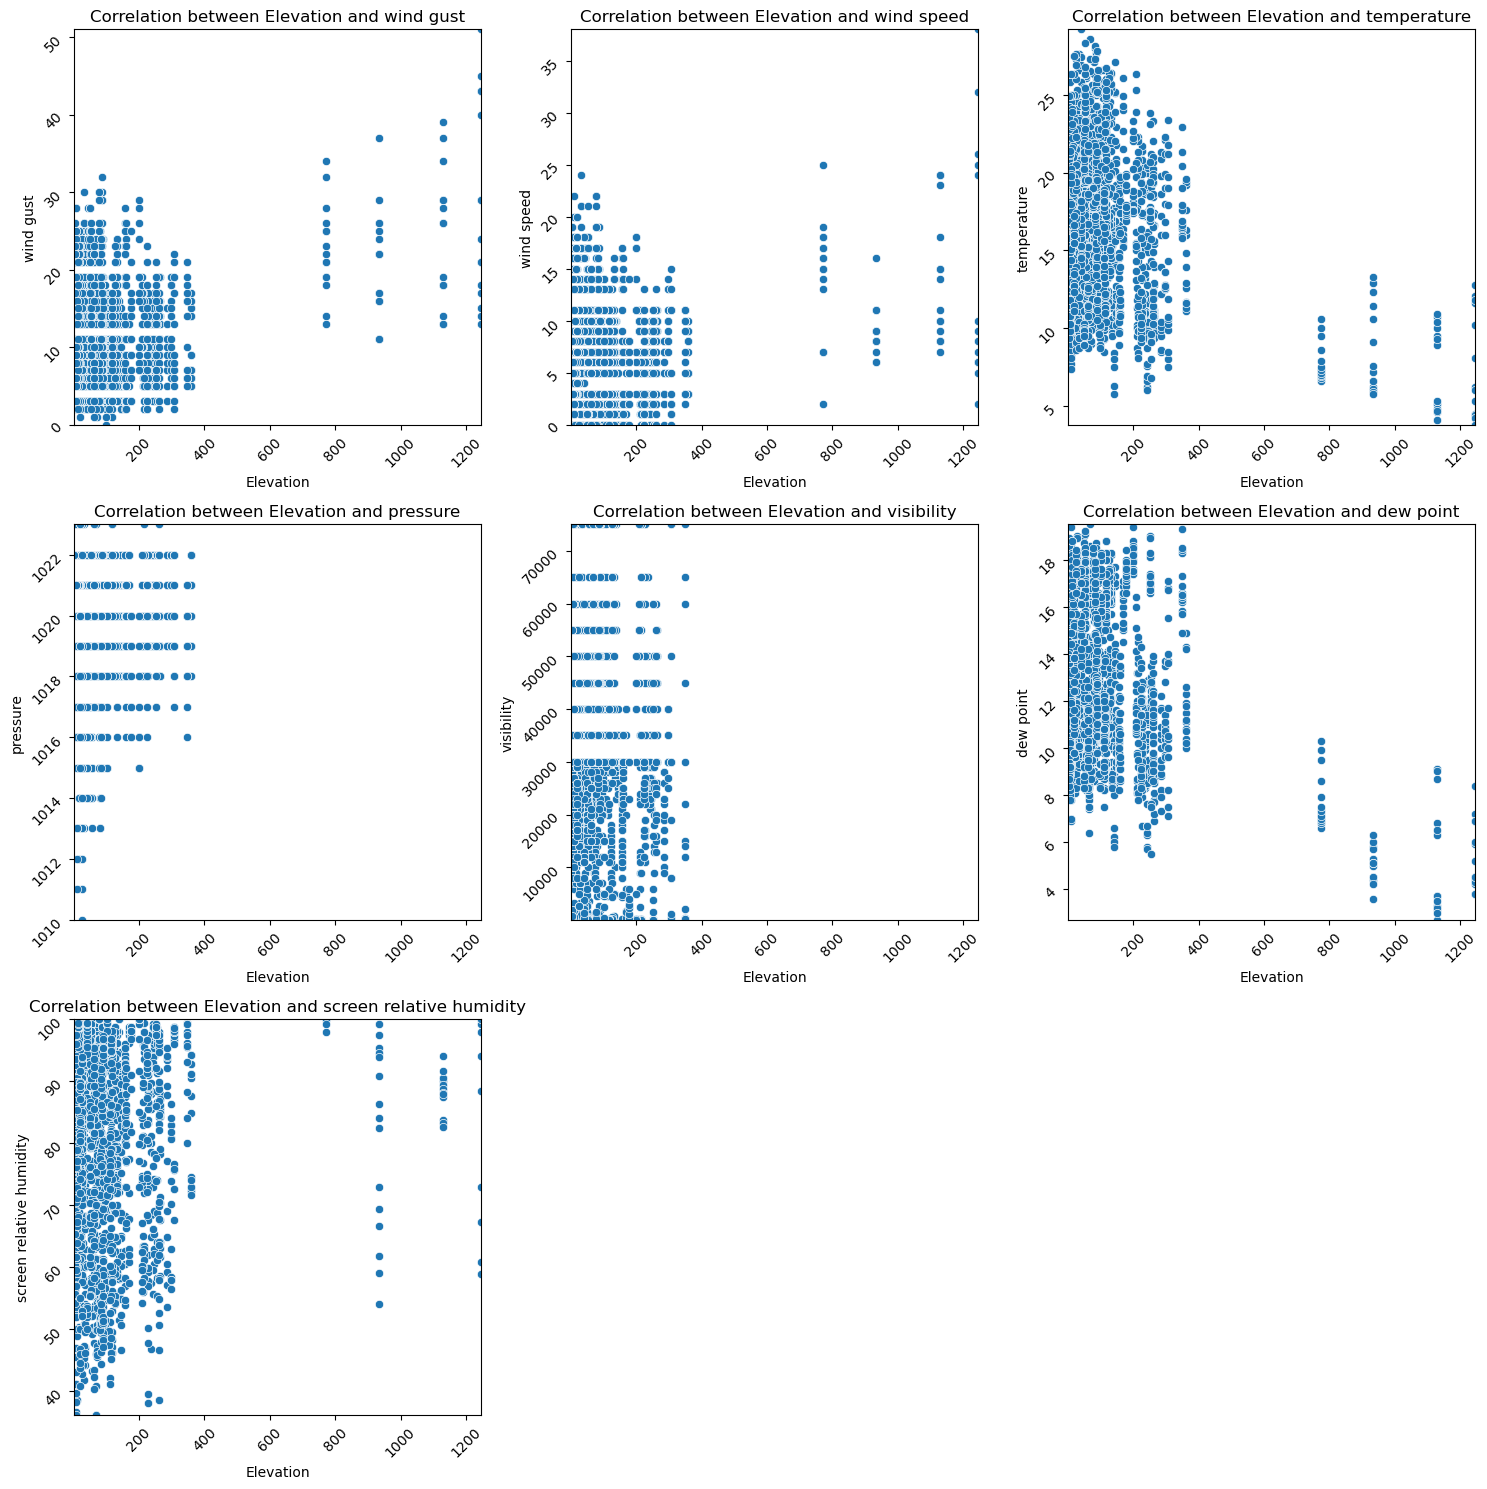

In [18]:

# Define numeric columns
numeric_columns = ['wind gust', 'wind speed', 'temperature', 'pressure', 'visibility', 'dew point', 'screen relative humidity', 'elevation']

# Set up the matplotlib figure with the appropriate grid size
plt.figure(figsize=(15, 15))

# Generate the grid of scatter plots with trend lines
for i, var in enumerate(numeric_columns[:-1]):  # Exclude 'elevation' from the loop
    plt.subplot(3, 3, i+1)  # Create a 3x3 grid for subplots
    sns.scatterplot(x=df2['elevation'], y=df2[var])
    
    
    # Set the title for each subplot
    plt.title(f'Correlation between Elevation and {var}')
    
    # Show axis ticks
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # Show min and max values on each axis
    plt.xlabel('Elevation')
    plt.ylabel(var)
    plt.xlim(df2['elevation'].min(), df1['elevation'].max())
    plt.ylim(df2[var].min(), df2[var].max())

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

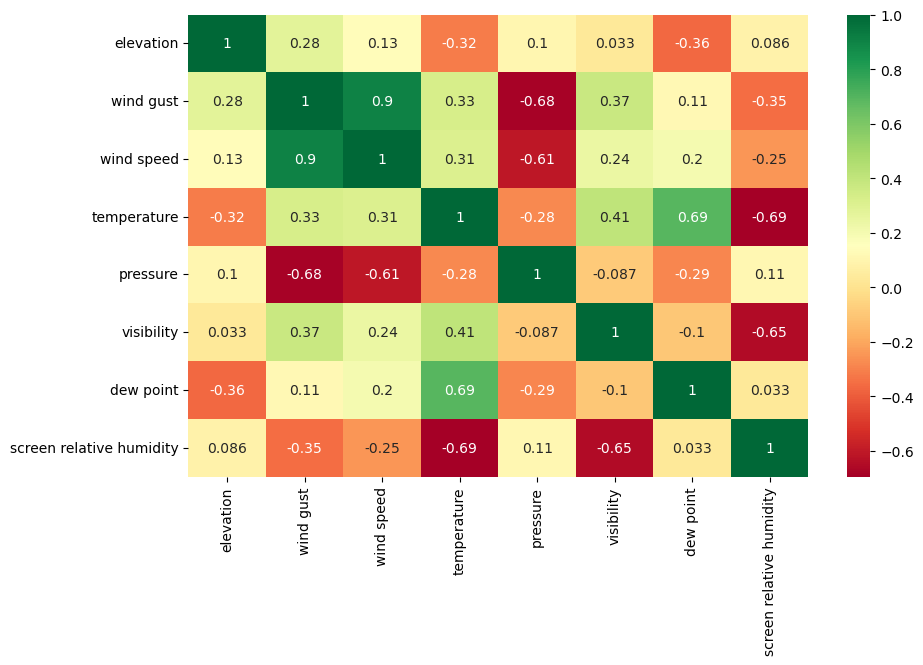

In [51]:
## Show the Correlation matrix for the numeric variables - atmospheric Pressure tends to decrease with Elevation (here corr = 0.1 >0)?
# which is counterintuitive. Can be explained by too many missing values in a small data set?

numeric_columns = ['elevation','wind gust', 'wind speed', 'temperature', 'pressure', 'visibility', 'dew point', 'screen relative humidity']
corrmat = df2[numeric_columns].corr(method ='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(10,6))
#plot heat map
g=sns.heatmap(df2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<font color='darkblue'>

## 3. __Identifying Missing Values and Outliers__

  - ### 3.1. Unit Testing for acceptable ranges
  - ### 3.2. Identifying missing(null) values
  - ### 3.3. Outlier detection using Interquartile Range (IQR)
  - ### 3.4. Analyzing missing values and outliers by location

</font>

<font color='darkblue'>

### 3.1. Unit Testing for acceptable ranges
</font>

<font color='darkblue'>

#### Unit Tests can verify that *Temperature* values fall within the acceptable range of -5 to 50 degrees, and that *Wind Speed* values are between   0 and  80. Values for *Elevation, Pressure, Visibility, Dew Point* and *Screen Relative Humidity* must be non-negative, with *Pressure* values not dropping below 872.5 millibars, which is the lowest atmospheric pressure ever recorded on Earth, during Typhoon Tip in 1979.
</font>

In [49]:
import unittest
import pandas as pd

class TestMetData(unittest.TestCase):

    def setUp(self):
        self.df1 = df1
        self.df2 = df2

    def check_column_range(self, df, column, min_val, max_val):
        failed_rows = []
        for index, row in df.iterrows():
            value = row[column]
            if pd.isna(value):
                continue  # Skip missing values
            elif not (min_val <= value <= max_val):
                print(f"{column.capitalize()} out of range at index {index}: {value}")
                failed_rows.append(index)
        return failed_rows

    def check_column_non_negative(self, df, column):
        failed_rows = []
        for index, row in df.iterrows():
            value = row[column]
            if pd.isna(value):
                continue  # Skip missing values
            elif value < 0:
                print(f"{column.capitalize()} has negative value at index {index}: {value}")
                failed_rows.append(index)
        return failed_rows

    def test_missing_values(self):
        # Combine the two dataframes to check for missing values in both
        combined_df = pd.concat([self.df1, self.df2])
        
        # Check for missing values and count them per column
        missing_values = combined_df.isnull().sum()
        
        # Filter out columns with no missing values
        missing_values = missing_values[missing_values > 0]
        
        if not missing_values.empty:
            print("\nMissing values found:")
            print(missing_values)
        else:
            print("\nNo missing values found.")


    def test_temperature_range(self):
        failed_rows1 = self.check_column_range(self.df1, 'temperature', -5, 50)
        failed_rows2 = self.check_column_range(self.df2, 'temperature', -5, 50)

        # Summarize results
        total_failed_rows = failed_rows1 + failed_rows2
        if total_failed_rows:
            print(f"\nTotal failed rows for temperature: {len(total_failed_rows)}")
            print(f"Indices of failed rows: {total_failed_rows}")

    def test_wind_speed_range(self):
        failed_rows1 = self.check_column_range(self.df1, 'wind speed', 0, 80)
        failed_rows2 = self.check_column_range(self.df2, 'wind speed', 0, 80)

        # Summarize results
        total_failed_rows = failed_rows1 + failed_rows2
        if total_failed_rows:
            print(f"\nTotal failed rows for wind speed: {len(total_failed_rows)}")
            print(f"Indices of failed rows: {total_failed_rows}")

    def test_non_negative_columns(self):
        columns_to_check = ['elevation', 'pressure', 'visibility', 'dew point', 'screen relative humidity']
        total_failed_rows = []
        
        for column in columns_to_check:
            failed_rows1 = self.check_column_non_negative(self.df1, column)
            failed_rows2 = self.check_column_non_negative(self.df2, column)
            total_failed_rows.extend(failed_rows1 + failed_rows2)

        if total_failed_rows:
            print(f"\nTotal failed rows for non-negative check: {len(total_failed_rows)}")
            print(f"Indices of failed rows: {total_failed_rows}")

    def test_pressure_min_value(self):
        failed_rows1 = self.check_column_range(self.df1, 'pressure', 872.5, float('inf'))
        failed_rows2 = self.check_column_range(self.df2, 'pressure', 872.5, float('inf'))

        # Summarize results
        total_failed_rows = failed_rows1 + failed_rows2
        if total_failed_rows:
            print(f"\nTotal failed rows for pressure: {len(total_failed_rows)}")
            print(f"Indices of failed rows: {total_failed_rows}")



if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


.


Missing values found:
wind gust                   275
temperature                  13
visibility                  415
wind direction              150
wind speed                  150
weather type                334
pressure                    213
pressure tendency           213
dew point                    13
screen relative humidity     13
dtype: int64


....
----------------------------------------------------------------------
Ran 5 tests in 0.768s

OK


<font color='darkblue'>

### 3.2. Identifying missing (null) values
</font>

In [218]:
def detect_nulls(df, columns):
    town_country_issues = []  # Initialize the list here

    # Iterate over each group of town and country
    for town_country, group in df.groupby(['town', 'country']):
        total_nulls = group.isnull().sum().sum()  # Total number of nulls in the group
        null_indices = group[group.isnull().any(axis=1)].index.tolist()  # Indices with nulls

        if total_nulls > 0:
            null_details = {}
            for idx in null_indices:
                # Count nulls for each column at the specific index
                null_columns = group.loc[idx].isnull().sum() 
                null_details[idx] = null_columns[null_columns > 0].to_dict() # Include only columns with nulls

            town_country_issues.append({
                'town_country': town_country,
                'total_nulls': total_nulls,
                'null_details': null_details
            })

    sorted_issues_nulls = sorted(town_country_issues, key=lambda x: x['total_nulls'], reverse=True)

    print("Sorted by Null Values:")
    for issue in sorted_issues_nulls:
        if issue['total_nulls'] > 0:
            print(f"{issue['town_country']} - Total Nulls: {issue['total_nulls']}")
            for idx, null_columns in issue['null_details'].items():
                print(f"Index {idx}: {null_columns}")
            print("\n")

# Analyze nulls and outliers for df2
detect_nulls(df2, numeric_columns)


Sorted by Null Values:
('SCARBOROUGH', 'ENGLAND') - Total Nulls: 105
Index 1985: {'wind gust': 1, 'visibility': 1, 'wind direction': 1, 'wind speed': 1, 'weather type': 1, 'pressure': 1, 'pressure tendency': 1}
Index 1986: {'wind gust': 1, 'visibility': 1, 'wind direction': 1, 'wind speed': 1, 'weather type': 1, 'pressure': 1, 'pressure tendency': 1}
Index 1987: {'wind gust': 1, 'visibility': 1, 'wind direction': 1, 'wind speed': 1, 'weather type': 1, 'pressure': 1, 'pressure tendency': 1}
Index 1988: {'wind gust': 1, 'visibility': 1, 'wind direction': 1, 'wind speed': 1, 'weather type': 1, 'pressure': 1, 'pressure tendency': 1}
Index 1989: {'wind gust': 1, 'visibility': 1, 'wind direction': 1, 'wind speed': 1, 'weather type': 1, 'pressure': 1, 'pressure tendency': 1}
Index 1990: {'wind gust': 1, 'visibility': 1, 'wind direction': 1, 'wind speed': 1, 'weather type': 1, 'pressure': 1, 'pressure tendency': 1}
Index 1991: {'wind gust': 1, 'visibility': 1, 'wind direction': 1, 'wind speed'

<font color='darkblue'>
    
### 3.3. Outlier detection using Interquartile Range (IQR)
</font>

In [56]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range (IQR)

    if column == 'temperature':
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    elif column in ['wind gust', 'wind speed']:
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 3.0 * IQR))]
    elif column == 'pressure':
        outliers = df[(df[column] < (Q1 - 3.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    elif column == 'dew point':
        outliers = df[(df[column] < (Q1 - 2.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    elif column == 'screen relative humidity':
        outliers = df[(df[column] < (Q1 - 2.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    elif column == 'visibility':
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    else:
        raise ValueError("Column not supported for outlier detection")

    print(f"Outlier values for '{column}':")
    if outliers.empty:
        print("No outliers detected.")
    else:
        for idx, row in outliers.iterrows():
                if not pd.isna(row[column]):
                    print(f"Index {idx}: ('{row['town']}', '{row['country']}')   {row[column]}")
            
    print()


# Detect outliers for temperature,pressure and wind speed
detect_outliers_iqr(df2, 'temperature')
detect_outliers_iqr(df2, 'pressure')
detect_outliers_iqr(df2, 'wind speed')
detect_outliers_iqr(df2, 'wind gust')
detect_outliers_iqr(df2, 'visibility')
detect_outliers_iqr(df2, 'dew point' )
detect_outliers_iqr(df2, 'screen relative humidity')


Outlier values for 'temperature':
No outliers detected.

Outlier values for 'pressure':
Index 1908: ('VALENTIA OBSERVATORY', 'IRELAND')   1011.0
Index 1909: ('VALENTIA OBSERVATORY', 'IRELAND')   1010.0
Index 1924: ('BELMULLET', 'IRELAND')   1011.0

Outlier values for 'wind speed':
Index 195: ('CAIRN GORM SUMMIT', 'SCOTLAND')   38.0
Index 198: ('CAIRN GORM SUMMIT', 'SCOTLAND')   32.0

Outlier values for 'wind gust':
Index 195: ('CAIRN GORM SUMMIT', 'SCOTLAND')   51.0
Index 198: ('CAIRN GORM SUMMIT', 'SCOTLAND')   45.0

Outlier values for 'visibility':
Index 25: ('LERWICK (S. SCREEN)', 'SCOTLAND')   75000.0
Index 58: ('KIRKWALL AIRPORT', 'SCOTLAND')   75000.0
Index 193: ('AVIEMORE', 'SCOTLAND')   75000.0
Index 194: ('AVIEMORE', 'SCOTLAND')   75000.0
Index 281: ('ABOYNE', 'SCOTLAND')   75000.0
Index 282: ('ABOYNE', 'SCOTLAND')   75000.0
Index 284: ('ABOYNE', 'SCOTLAND')   75000.0
Index 418: ('STRATHALLAN', 'SCOTLAND')   75000.0
Index 419: ('STRATHALLAN', 'SCOTLAND')   75000.0
Index 767: (

<font color='darkblue'>
    
### 3.4. Analyzing missing values and outliers by location
</font>

In [25]:
def detect_nulls_and_outliers(df, columns):
    town_country_issues = []  # Initialize the list here
    
    # Calculate quartiles and IQR for the entire dataset
    IQR_values = {}
    for column in columns:  # Iterate through each column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        IQR_values[column] = (Q1, Q3, IQR)  # Store the quartiles and IQR
    
    # Iterate over each group of town and country
    for town_country, group in df.groupby(['town', 'country']):
        null_counts = group.isnull().sum().sum()
        null_indices = group[group.isnull().any(axis=1)].index.tolist()
        null_columns = {col: count for col, count in group.isnull().sum().items() if count > 0}  # Exclude zero counts

        outlier_counts_temp = 0
        outlier_indices_temp = []
        outlier_values_temp = []

        outlier_counts_wind = 0
        outlier_indices_wind = []
        outlier_values_wind = []

        outlier_counts_pres = 0
        outlier_indices_pres = []
        outlier_values_pres = []

        # Identify outliers for temperature
        Q1, Q3, IQR = IQR_values['temperature']
        iqr_outliers_temp = group[(group['temperature'] < (Q1 - 1.5 * IQR)) | (group['temperature'] > (Q3 + 1.5 * IQR))]
        outlier_counts_temp += iqr_outliers_temp.shape[0]
        outlier_indices_temp.extend(iqr_outliers_temp.index.tolist())
        outlier_values_temp.extend(iqr_outliers_temp['temperature'].tolist())
        
      
        # Identify outliers for wind speed
        Q1, Q3, IQR = IQR_values['wind speed']
        iqr_outliers_wind = group[(group['wind speed'] < (Q1 - 1.5 * IQR)) | (group['wind speed'] > (Q3 + 3.0 * IQR))]
        outlier_counts_wind += iqr_outliers_wind.shape[0]
        outlier_indices_wind.extend(iqr_outliers_wind.index.tolist())
        outlier_values_wind.extend(iqr_outliers_wind['wind speed'].tolist())

        # Identify outliers for pressure
        Q1, Q3, IQR = IQR_values['pressure']
        iqr_outliers_pres = group[(group['pressure'] < (Q1 - 3.0 * IQR)) | (group['pressure'] > (Q3 + 3.0 * IQR))]
        outlier_counts_pres += iqr_outliers_pres.shape[0]
        outlier_indices_pres.extend(iqr_outliers_pres.index.tolist())
        outlier_values_pres.extend(iqr_outliers_pres['pressure'].tolist())

        if null_counts > 0 or outlier_counts_temp > 0 or outlier_counts_wind > 0 or outlier_counts_pres > 0:
            town_country_issues.append({
                'town_country': town_country,
                'total_nulls': null_counts,
                'null_columns': null_columns,
                'null_indices': null_indices,
                'total_outliers_temp': outlier_counts_temp,
                'outlier_values_temp': outlier_values_temp,
                'outlier_indices_temp': outlier_indices_temp,
                'total_outliers_wind': outlier_counts_wind,
                'outlier_values_wind': outlier_values_wind,
                'outlier_indices_wind': outlier_indices_wind,
                'total_outliers_pres': outlier_counts_pres,
                'outlier_values_pres': outlier_values_pres,
                'outlier_indices_pres': outlier_indices_pres
            })

    sorted_issues_nulls = sorted(town_country_issues, key=lambda x: x['total_nulls'], reverse=True)
    sorted_issues_outliers = sorted(town_country_issues, key=lambda x: (x['total_outliers_temp'] + x['total_outliers_wind'] + x['total_outliers_pres']), reverse=True)

    print("Sorted by Null Values:")
    for issue in sorted_issues_nulls:
        if issue['total_nulls'] > 0:
            print(f"{issue['town_country']} - Total Nulls: {issue['total_nulls']}")
            print(f"Null Columns: {issue['null_columns']}")
            print(f"Null Indices: {issue['null_indices']}\n")
        
    print("Sorted by Outliers:")
    for issue in sorted_issues_outliers:
        if issue['total_outliers_temp'] > 0:
            print(f"\n{issue['town_country']} - Total Temperature Outliers: {issue['total_outliers_temp']}")
            for idx, val in zip(issue['outlier_indices_temp'], issue['outlier_values_temp']):
                print(f"Index {idx}: {val}")
        if issue['total_outliers_wind'] > 0:
            print(f"\n{issue['town_country']} - Total Wind Speed Outliers: {issue['total_outliers_wind']}")
            for idx, val in zip(issue['outlier_indices_wind'], issue['outlier_values_wind']):
                print(f"Index {idx}: {val}")
        if issue['total_outliers_pres'] > 0:
            print(f"\n{issue['town_country']} - Total Pressure Outliers: {issue['total_outliers_pres']}")
            for idx, val in zip(issue['outlier_indices_pres'], issue['outlier_values_pres']):
                print(f"Index {idx}: {val}")

# Analyze nulls and outliers for df2
detect_nulls_and_outliers(df2, numeric_columns)


Sorted by Null Values:
('SCARBOROUGH', 'ENGLAND') - Total Nulls: 105
Null Columns: {'wind gust': 15, 'visibility': 15, 'wind direction': 15, 'wind speed': 15, 'weather type': 15, 'pressure': 15, 'pressure tendency': 15}
Null Indices: [1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]

('STONYHURST', 'ENGLAND') - Total Nulls: 105
Null Columns: {'wind gust': 15, 'visibility': 15, 'wind direction': 15, 'wind speed': 15, 'weather type': 15, 'pressure': 15, 'pressure tendency': 15}
Null Indices: [1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969]

('WOBURN', 'ENGLAND') - Total Nulls: 105
Null Columns: {'wind gust': 15, 'visibility': 15, 'wind direction': 15, 'wind speed': 15, 'weather type': 15, 'pressure': 15, 'pressure tendency': 15}
Null Indices: [1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954]

('ROTHAMSTED', 'ENGLAND') - Total Nulls: 75
Null Columns: {'wind gust': 15

<font color='darkblue'>
    
## 4. __Imputing missing data__
- ### 4.1. Imputing missing numeric data using linear interpolation and nearest neighbor averaging
    - #### 4.1.1. Visualising UK weather locations  with a Folium map
    - #### 4.1.2. Imputing missing values for numeric variables
- ### 4.2. Visualizing imputed data for numeric variables
- ### 4.3. Imputing missing Weather Type (Categorical Data) using the XGBoost model
</font>

<font color='darkblue'>

### 4.1. Imputing missing values for the numerical measures by linear interpolation and by averaging the observations from two closest locations
</font>

<font color='darkblue'>

### 4.1.1. Visualising UK weather locations  with a Folium map
</font>

In [6]:

# List of towns in the UK
towns = ['BALTASOUND', 'LERWICK (S. SCREEN)', 'FAIR ISLE',
       'KIRKWALL AIRPORT', 'SOUTH UIST RANGE', 'STORNOWAY AIRPORT',
       'LOCH GLASCARNOCH', 'AULTBEA', 'BEALACH NA BA',
       'AONACH MOR SUMMIT', 'ALTNAHARRA SAWS', 'TULLOCH BRIDGE',
       'AVIEMORE', 'CAIRN GORM SUMMIT', 'KINLOSS', 'LOSSIEMOUTH',
       'CAIRNWELL', 'WICK JOHN O GROATS AIRPORT', 'ABOYNE', 'INVERBERVIE',
       'ABERDEEN AIRPORT', 'TIREE', 'ISLAY AIRPORT',
       'CAMPBELTOWN AIRPORT', 'WEST FREUGH', 'GLASGOW/BISHOPTON',
       'PRESTWICK RNAS', 'STRATHALLAN', 'DUNDRENNAN', 'DRUMALBIN',
       'CHARTERHALL', 'ESKDALEMUIR', 'EDINBURGH/GOGARBANK', 'LEUCHARS',
       'RONALDSWAY', 'ST. BEES HEAD', 'KESWICK', 'WALNEY ISLAND',
       'CARLISLE', 'SPADEADAM', 'SHAP', 'WARCOP', 'REDESDALE CAMP',
       'ALBEMARLE', 'BOULMER', 'LEEMING', 'TOPCLIFFE', 'LOFTUS (SAMOS)',
       'FYLINGDALES', 'BRIDLINGTON MRSC', 'VALLEY', 'CAPEL CURIG', 'RHYL',
       'CROSBY', 'HAWARDEN', 'THORNECLIFFE LEEK', 'BINGLEY SAMOS',
       'ROSTHERNE NO 2', 'WATNALL', 'WADDINGTON', 'CRANWELL',
       'LECONFIELD SAR', 'DONNA NOOK', 'CONINGSBY', 'WAINFLEET',
       'ABERDARON', 'LAKE VYRNWY SAWS', 'SHAWBURY', 'WITTERING',
       'HOLBEACH', 'MARHAM', 'WEYBOURNE', 'ABERPORTH', 'TRAWSGOED',
       'SENNYBRIDGE', 'SHOBDON SAWS', 'CREDENHILL', 'THROCKMORTON',
       'COLESHILL', 'CHURCH LAWFORD', 'BEDFORD', 'WATTISHAM',
       'MILFORD HAVEN C.B.', 'PEMBREY SANDS', 'LITTLE RISSINGTON (ESAWS)',
       'BRIZE NORTON', 'BENSON', 'NORTHOLT', 'ROTHAMSTED', 'ANDREWSFIELD',
       'SHOEBURYNESS', 'CHIVENOR', 'LISCOMBE', 'ST-ATHAN', 'LYNEHAM',
       'LARKHILL', 'BOSCOMBE DOWN', 'MIDDLE WALLOP', 'ODIHAM',
       'CHARLWOOD', 'HEATHROW', 'KENLEY', 'LANGDON BAY', 'MANSTON',
       'SCILLY ST MARYS', 'CAMBORNE', 'CULDROSE', 'CARDINHAM',
       'MOUNT BATTEN', 'DUNKESWELL AERODROME', 'EXETER AIRPORT',
       'YEOVILTON', 'ISLE OF PORTLAND', 'BOURNEMOUTH AIRPORT',
       'ST CATHERINES PT.', 'THORNEY ISLAND', 'SHOREHAM',
       'HERSTMONCEUX WEST END', 'GUERNSEY', 'JERSEY', 'CASTLEDERG',
       'MAGILLIGAN', 'LOUGH FEA', 'BALLYPATRICK FOREST',
       'BELFAST INTERNATIONAL AIRPORT', 'GLENANNE', 'ROCHES POINT',
       'VALENTIA OBSERVATORY', 'BELMULLET', 'MALIN HEAD', 'WOBURN',
       'STONYHURST', 'NORTH WYKE', 'SCARBOROUGH']

In [7]:
def create_town_coordinates_dict(df, towns):
    town_coordinates = {}
    
    for town in towns:
        town_data = df[df['town'] == town]
        if not town_data.empty:
            lat = town_data['lat'].values[0]
            lon = town_data['lon'].values[0]
            town_coordinates[town] = (lat, lon)
    
    return town_coordinates

# create the dictionary with df2
town_coordinates = create_town_coordinates_dict(df2, towns)
#town_coordinates

In [10]:
from geopy.geocoders import GoogleV3

# Define your Google Maps API key
api_key = 'my API key'

# Initialize the Google Maps geocoder
geolocator = GoogleV3(api_key=api_key)

# Dictionary to store town coordinates with Google's geolocator
town_coordinates = {}
# Retrieve coordinates for each town
for town in towns:
    location = geolocator.geocode(town + ', UK')
    if location:
        town_coordinates[town] = (location.latitude, location.longitude)


In [14]:
# Create a map centered on the UK
uk_map = folium.Map(location=[54.7023545, -3.2765753], zoom_start=6)

# Add markers for each town with its coordinates
for town, coordinates in town_coordinates.items():
    folium.Marker(location=[coordinates[0], coordinates[1]], popup=town).add_to(uk_map)

# Save the map to an HTML file
uk_map.save('uk_town_coordinates_map.html')

# Display the map 
IFrame(src='uk_town_coordinates_map.html', width=700, height=600)

#### Example image for 'CARLISLE'

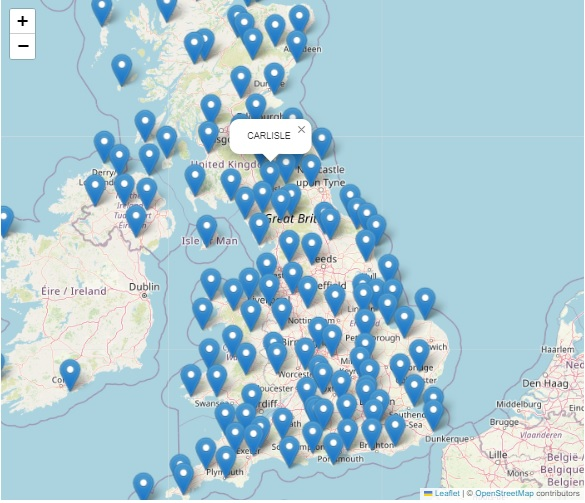

In [320]:

# Function to the two closest towns to a given town
def get_closest_towns(town_name, town_coordinates, num_closest=2):
    """
    Find the closest towns to a given town.

    Parameters:
    - town_name (str): The name of the town for which to find the closest towns.
    - town_coordinates (dict): A dictionary with town names as keys and (latitude, longitude) tuples as values.
    - num_closest (int): The number of closest towns to return (default is 2).

    Returns:
    - closest_town_names (list): A list of the closest town names.
    """
    # Get coordinates of the given town
    town_coords = town_coordinates[town_name]
    
    # List to store distances
    distances = []

    # Calculate distance from the given town to each other town
    for town, coords in town_coordinates.items():
        if town != town_name:  # Skip the given town itself
            distance = geodesic(town_coords, coords).kilometers
            distances.append((town, distance))

    # Sort the list by distance
    distances.sort(key=lambda x: x[1])

    # Get the names of the closest towns
    closest_town_names = [item[0] for item in distances[:num_closest]]
    
    return closest_town_names


# Get the two closest towns and their distances
#closest_towns = distances[:2]

# Get the two closet town names
#closest_town_names = [item[0] for item in closest_towns]
#print(closest_town_names)

#closest_towns = [distances[0][0], distances[1][0]]
#print(closest_towns)

# Print the results
#for town, distance in closest_towns:
#    print(f"The town {town} is {distance:.2f} km away from Carlisle.")


In [322]:
# Example usage for 'CARLISLE'

closest_towns = get_closest_towns('CARLISLE', town_coordinates)
print(closest_towns)


['SPADEADAM', 'KESWICK']


<font color='darkblue'>

### 4.1.2. Imputing missing values for numeric variables¶
</font>

<font color='darkblue'>
    
#### The function impute_missing_values(df, columns) handles two cases:
    
- Linear Interpolation: If there are other known values for a location, the missing values are imputed by linear interpolation.
- Using neighboring locations: If no other values are known for a location,  the missing values are imputed by averaging the values from the two closest locations. The closest locations are identified based on their distances from each given location using geodesic() from the geopy.distance module.

</font>    

In [22]:
def impute_missing_values(df, columns, town_coordinates, print_output=False):
    """
    Impute missing values in a DataFrame using data from the closest towns.

    This function fills missing values in specified columns by first applying
    linear interpolation within each town. If there are still missing values,
    it imputes them by averaging the corresponding values from the two closest
    towns, based on geographical distance. If a closest town has missing values,
    it checks for an additional closest town. If there are still no valid values,
    it prints a message stating that no data is available for imputation at that town.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data with missing values.
    - columns (list): A list of column names in which to impute missing values.
    - town_coordinates (dict): A dictionary with town names as keys and (latitude, longitude) tuples as values.
    - print_output (bool): Whether to print debug output for a specific town (default is True).

    Returns:
    - df (pd.DataFrame): The DataFrame with missing values imputed.
    """

    for column in columns:
        # First, fill the first row of each town if it has missing values using the first available value
        for town, group in df.groupby('town'):
            first_valid_index = group[column].first_valid_index()
            if first_valid_index is not None and first_valid_index != group.index[0]:
                df.loc[group.index[0], column] = df.loc[first_valid_index, column]  # Fill missing value in the first row with the next available value

        # Perform linear interpolation within each group if there are other known values for a location
        df[column] = df.groupby('town', group_keys=False)[column].apply(lambda group: group.interpolate(method='linear'))

        # Find rows that still have NaN values after interpolation and process them town by town
        nan_rows = df[df[column].isna()]

        for town_name in nan_rows['town'].unique():
            town_coords = town_coordinates[town_name]

            # Calculate distances to all other towns
            distances = []
            for other_town, coords in town_coordinates.items():
                if other_town != town_name:
                    # Calculate the distance using geodesic
                    distance = geodesic(town_coords, coords).kilometers
                    distances.append((other_town, distance))
           
            # Sort by distance and find the two closest towns
            distances.sort(key=lambda x: x[1])
            closest_towns = [distances[0][0], distances[1][0]]
            print(f"Closest Towns: {closest_towns}, Distances: {distances[0][1], distances[1][1]} kilometers")
            valid_closest_towns = []

            # Check for NaNs in closest town data and search for additional towns if necessary
            for closest_town in closest_towns:
                closest_town_rows = df[df['town'] == closest_town].head(len(nan_rows))
                if not np.isnan(closest_town_rows[column].values).all():
                    valid_closest_towns.append(closest_town)
                else:
                    # Look for the next closest town
                    for dist in distances[2:]:
                        further_town = dist[0]
                        
                        further_town_rows = df[df['town'] == further_town].head(len(nan_rows))
                        if not np.isnan(further_town_rows[column].values).all():
                            valid_closest_towns.append(further_town)
                            break
                    print(f"Additional Town: {further_town}, Distance: {dist[1]} kilometers")
            if not valid_closest_towns:
                print(f"No data available to impute missing values for {town_name}.")
                continue

            if print_output:
                print(f"Valid Closest Towns for {town_name}: {valid_closest_towns}")

            # Gather the values from the valid closest towns for averaging
            closest_town_values = []
            for valid_town in valid_closest_towns:
                valid_town_rows = df[df['town'] == valid_town].head(len(nan_rows))
                closest_town_values.append(valid_town_rows[column].values)

            # Calculate the average values for the missing rows
            avg_values = []
            for i in range(len(nan_rows)):
                valid_values = [values[i] for values in closest_town_values if len(values) > i and not np.isnan(values[i])]
                if valid_values:
                    avg_value = np.mean(valid_values)
                else:
                    avg_value = np.nan  # Keep NaN if no valid data is available
                avg_values.append(avg_value)

            # Fill in the missing values in the DataFrame
            town_nan_indexes = df[(df['town'] == town_name) & df[column].isnull()].index
            for idx, avg_value in zip(town_nan_indexes, avg_values):
                df.at[idx, column] = avg_value
                if print_output:
                    print(f"Imputed value for row {idx}: {avg_value:.2f}")

    return df

In [23]:
# Example usage
numeric_columns = ['temperature']
df_imputed1 = impute_missing_values(df2.copy(), numeric_columns, town_coordinates, print_output=True)

Closest Towns: ['CAPEL CURIG', 'ABERDARON'], Distances: (47.51348275779586, 54.178256144568444) kilometers
Valid Closest Towns for VALLEY: ['CAPEL CURIG', 'ABERDARON']
Imputed value for row 750: 13.35
Imputed value for row 751: 13.75
Imputed value for row 752: 13.05
Imputed value for row 753: 12.50
Imputed value for row 754: 12.45


In [25]:
numeric_column = ['wind speed']
# Example usage with print statements enabled:
df_imputed2 = impute_missing_values(df_imputed1, numeric_column, town_coordinates, print_output=True)

In [26]:
numeric_column = ['wind gust']
# Example usage with print statements enabled:
df_imputed3 = impute_missing_values(df_imputed2, numeric_column, town_coordinates, print_output=True)

Closest Towns: ['SPADEADAM', 'KESWICK'], Distances: (23.635127306388306, 34.92290306549991) kilometers
Valid Closest Towns for CARLISLE: ['SPADEADAM', 'KESWICK']
Imputed value for row 570: 6.00
Imputed value for row 571: 5.00
Imputed value for row 572: 7.50
Imputed value for row 573: 8.00
Imputed value for row 574: 7.00
Imputed value for row 575: 3.00
Imputed value for row 576: 5.50
Imputed value for row 577: 5.00
Imputed value for row 578: 8.00
Imputed value for row 579: 9.00
Imputed value for row 580: 7.50
Imputed value for row 581: 9.00
Imputed value for row 582: 10.00
Imputed value for row 583: 13.00
Imputed value for row 584: 12.00
Closest Towns: ['WOBURN', 'NORTHOLT'], Distances: (26.95953293270263, 29.207200465292352) kilometers
Additional Town: BEDFORD, Distance: 37.46225396852272 kilometers
Valid Closest Towns for ROTHAMSTED: ['BEDFORD', 'NORTHOLT']
Imputed value for row 1310: 5.50
Imputed value for row 1311: 5.00
Imputed value for row 1312: 5.50
Imputed value for row 1313: 5.

In [27]:
numeric_column = ['pressure']
# Example usage with print statements enabled:
df_imputed4 = impute_missing_values(df_imputed3, numeric_column, town_coordinates, print_output=True)

Closest Towns: ['AULTBEA', 'LOCH GLASCARNOCH'], Distances: (47.86363623708737, 61.98445402354632) kilometers
Valid Closest Towns for BEALACH NA BA: ['AULTBEA', 'LOCH GLASCARNOCH']
Imputed value for row 120: 1018.00
Imputed value for row 121: 1018.00
Imputed value for row 122: 1018.00
Imputed value for row 123: 1018.00
Imputed value for row 124: 1019.00
Imputed value for row 125: 1019.00
Imputed value for row 126: 1019.50
Imputed value for row 127: 1019.50
Imputed value for row 128: 1020.00
Imputed value for row 129: 1020.00
Imputed value for row 130: 1020.00
Imputed value for row 131: 1020.00
Imputed value for row 132: 1020.00
Imputed value for row 133: 1019.50
Imputed value for row 134: 1019.00
Closest Towns: ['ST CATHERINES PT.', 'AVIEMORE'], Distances: (66.27578104836668, 80.97605307317323) kilometers
Valid Closest Towns for AONACH MOR SUMMIT: ['ST CATHERINES PT.', 'AVIEMORE']
Imputed value for row 135: 1020.00
Imputed value for row 136: 1020.00
Imputed value for row 137: 1020.00
Im

In [28]:
numeric_column = ['visibility']
# Example usage with print statements enabled:
df_imputed5 = impute_missing_values(df_imputed4, numeric_column, town_coordinates, print_output=True)

Closest Towns: ['AULTBEA', 'LOCH GLASCARNOCH'], Distances: (47.86363623708737, 61.98445402354632) kilometers
Valid Closest Towns for BEALACH NA BA: ['AULTBEA', 'LOCH GLASCARNOCH']
Imputed value for row 120: 23500.00
Imputed value for row 121: 30500.00
Imputed value for row 122: 29500.00
Imputed value for row 123: 29000.00
Imputed value for row 124: 27500.00
Imputed value for row 125: 27500.00
Imputed value for row 126: 39500.00
Imputed value for row 127: 31500.00
Imputed value for row 128: 37500.00
Imputed value for row 129: 37500.00
Imputed value for row 130: 42500.00
Imputed value for row 131: 45000.00
Imputed value for row 132: 45000.00
Imputed value for row 133: 50000.00
Imputed value for row 134: 42500.00
Closest Towns: ['ST CATHERINES PT.', 'AVIEMORE'], Distances: (66.27578104836668, 80.97605307317323) kilometers
Additional Town: BEALACH NA BA, Distance: 81.00597142400593 kilometers
Valid Closest Towns for AONACH MOR SUMMIT: ['BEALACH NA BA', 'AVIEMORE']
Imputed value for row 135

In [29]:
numeric_column = ['dew point']
# Example usage with print statements enabled:
df_imputed6 = impute_missing_values(df_imputed5, numeric_column, town_coordinates, print_output=True)

Closest Towns: ['CAPEL CURIG', 'ABERDARON'], Distances: (47.51348275779586, 54.178256144568444) kilometers
Valid Closest Towns for VALLEY: ['CAPEL CURIG', 'ABERDARON']
Imputed value for row 750: 12.55
Imputed value for row 751: 13.10
Imputed value for row 752: 12.55
Imputed value for row 753: 12.10
Imputed value for row 754: 12.15


In [30]:
numeric_column = ['screen relative humidity']
# Example usage with print statements enabled:
df_imputed7 = impute_missing_values(df_imputed6, numeric_column, town_coordinates, print_output=True)

Closest Towns: ['CAPEL CURIG', 'ABERDARON'], Distances: (47.51348275779586, 54.178256144568444) kilometers
Valid Closest Towns for VALLEY: ['CAPEL CURIG', 'ABERDARON']
Imputed value for row 750: 94.85
Imputed value for row 751: 95.85
Imputed value for row 752: 96.80
Imputed value for row 753: 97.35
Imputed value for row 754: 98.05


In [78]:
# Check if any numerical column still contains missing values

df_imputed7.isna().sum()

i                             0
lat                           0
lon                           0
town                          0
country                       0
elevation                     0
date                          0
wind gust                     0
temperature                   0
visibility                    0
wind direction               90
wind speed                    0
weather type                194
pressure                      0
pressure tendency           128
dew point                     0
screen relative humidity      0
dtype: int64

<font color='darkblue'>

#### Example of imputed missing values for VALLEY, WALES
</font>

In [35]:
# After imputation

df_imputed7.loc[df2.town=='VALLEY']

,i,lat,lon,town,country,elevation,date,wind gust,temperature,visibility,wind direction,wind speed,weather type,pressure,pressure tendency,dew point,screen relative humidity
750,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,13.0,13.35,29500.0,S,7.0,NaN,1022.0,NaN,12.55,94.85
751,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,9.0,13.75,31000.0,E,6.0,NaN,1022.0,NaN,13.10,95.85
752,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,6.0,13.05,25500.0,E,3.0,NaN,1021.5,NaN,12.55,96.80
753,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,5.0,12.50,7650.0,ENE,3.0,NaN,1021.5,NaN,12.10,97.35
754,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,6.0,12.45,15000.0,E,3.0,NaN,1021.5,NaN,12.15,98.05


In [34]:
# Before imputation
df2.loc[df2.town=='VALLEY']

,i,lat,lon,town,country,elevation,date,wind gust,temperature,visibility,wind direction,wind speed,weather type,pressure,pressure tendency,dew point,screen relative humidity
750,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,13.0,NaN,NaN,S,7.0,NaN,NaN,NaN,NaN,NaN
751,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,9.0,NaN,NaN,E,6.0,NaN,NaN,NaN,NaN,NaN
752,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,6.0,NaN,NaN,E,3.0,NaN,NaN,NaN,NaN,NaN
753,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,5.0,NaN,NaN,ENE,3.0,NaN,NaN,NaN,NaN,NaN
754,3302,53.252,-4.537,VALLEY,WALES,10.0,2024-08-11,6.0,NaN,NaN,E,3.0,NaN,NaN,NaN,NaN,NaN


<font color='darkblue'>

### 4.3. Visualizing imputed data for numeric variables
</font>

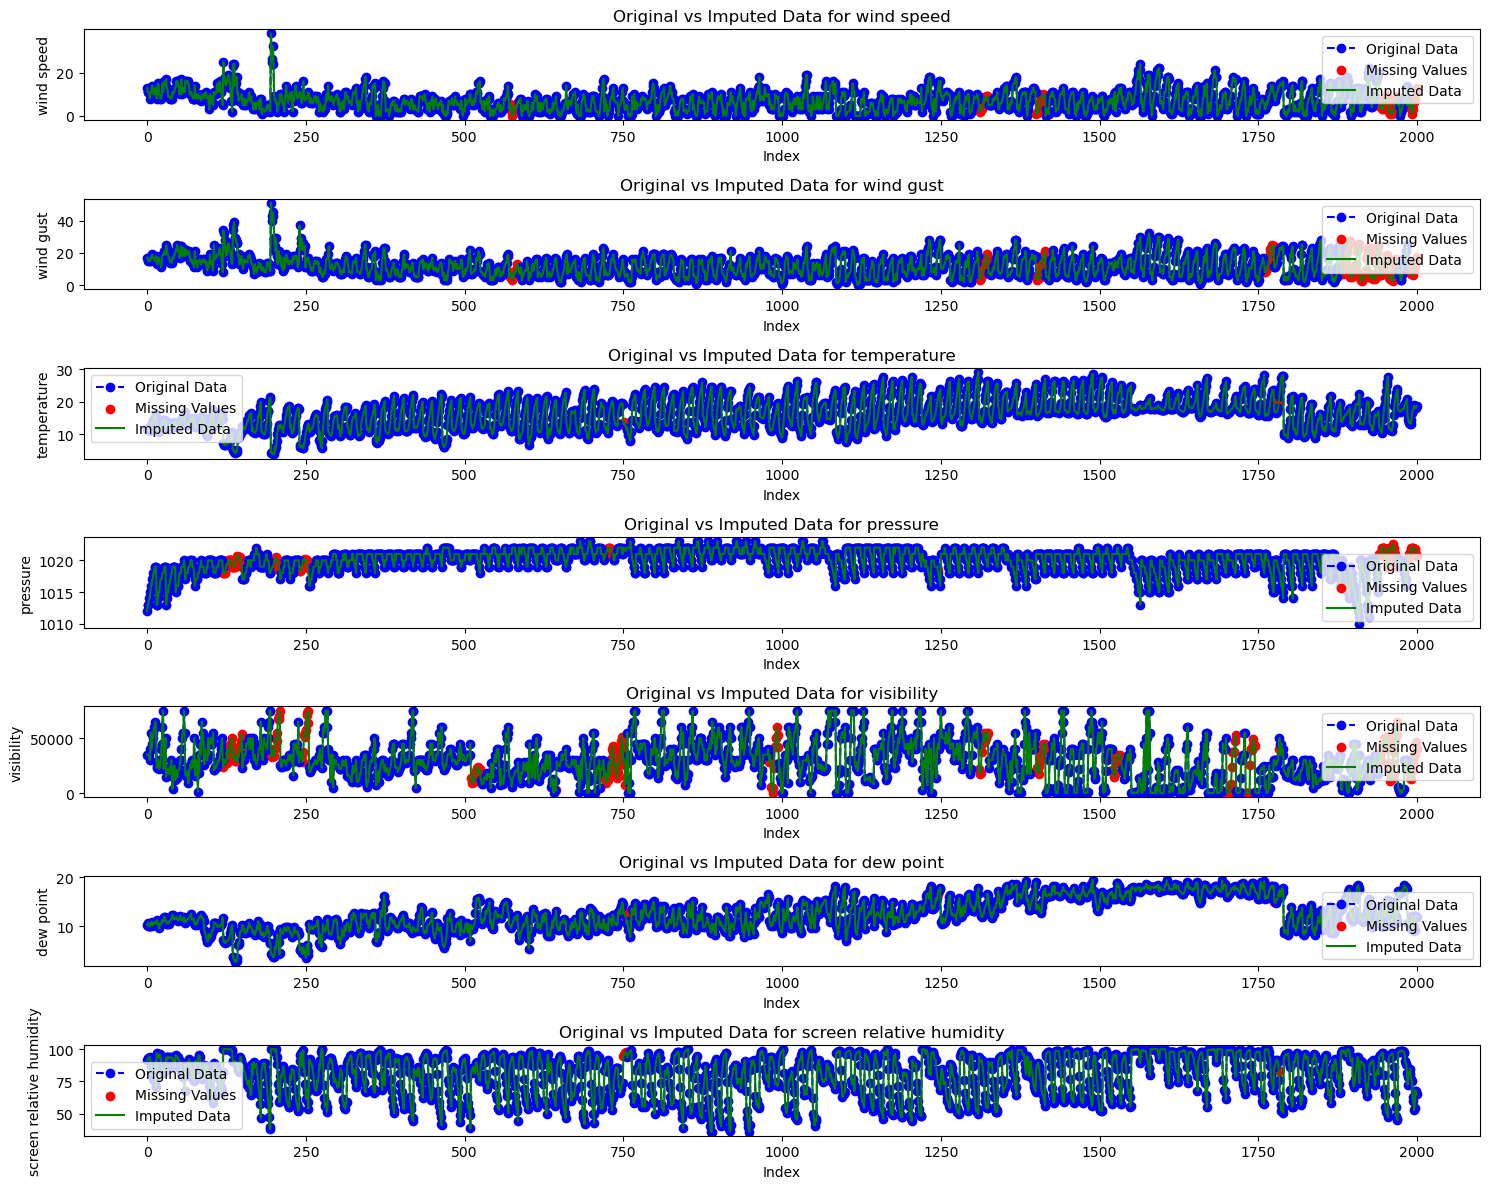

In [50]:
# Function to visualize imputed data
def visualize_imputation(df_original, df_imputed, columns):
    plt.figure(figsize=(15, 12))
    
    for i, column in enumerate(columns):
        plt.subplot(len(columns), 1, i + 1)
        
        # Plot original data with missing values
        plt.plot(df_original.index, df_original[column], label='Original Data', color='blue', linestyle='--', marker='o')
        
        # Highlight missing values in the original data
        plt.scatter(df_original.index[df_original[column].isna()], 
                    df_imputed[column][df_original[column].isna()], 
                    color='red', label='Missing Values')
        
        # Plot imputed data
        plt.plot(df_imputed.index, df_imputed[column], label='Imputed Data', color='green')
        
        plt.title(f'Original vs Imputed Data for {column}')
        plt.legend()
        plt.xlabel('Index')
        plt.ylabel(column)

    plt.tight_layout()
    plt.show()



# Visualize the imputation

numeric_columns = [ 'wind speed', 'wind gust','temperature', 'pressure', 'visibility', 'dew point', 'screen relative humidity']
visualize_imputation(df2, df_imputed7, numeric_columns)


<font color='darkblue'>

### 4.3. Imputing missing Weather Type (Categorical Data) using the XGBoost model
</font>

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb


In [271]:
df_imputed7.isna().sum()

i                             0
lat                           0
lon                           0
town                          0
country                       0
elevation                     0
date                          0
wind gust                     0
temperature                   0
visibility                    0
wind direction               90
wind speed                    0
weather type                194
pressure                      0
pressure tendency           128
dew point                     0
screen relative humidity      0
dtype: int64

In [37]:
df_imputed7_ = df_imputed7.dropna()
df_imputed7_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1776 entries, 0 to 1984
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   i                         1776 non-null   object        
 1   lat                       1776 non-null   float64       
 2   lon                       1776 non-null   float64       
 3   town                      1776 non-null   object        
 4   country                   1776 non-null   object        
 5   elevation                 1776 non-null   float64       
 6   date                      1776 non-null   datetime64[ns]
 7   wind gust                 1776 non-null   float64       
 8   temperature               1776 non-null   float64       
 9   visibility                1776 non-null   float64       
 10  wind direction            1776 non-null   object        
 11  wind speed                1776 non-null   float64       
 12  weather type        

In [38]:
X = df_imputed7_.drop(['weather type', 'i', 'lat', 'lon', 'town', 'country', 'date'], axis=1)  # Assuming 'weather_type' is the column name for weather type


# Identify categorical features
categorical_features = ['wind direction', 'pressure tendency']

# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


numerical_features = ['wind speed', 'wind gust', 'temperature', 'pressure', 'visibility', 'dew point', 'screen relative humidity', 'elevation']

# Standardize the numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

y = df_imputed7_['weather type']

# Encode the target variable (weather type) to numeric values
y_le = LabelEncoder()
y = y_le.fit_transform(y)

In [39]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)


In [290]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_))

# Train the model
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [40]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [80, 150, 200],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_le.classes_), eval_metric='mlogloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\maria\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.58


In [41]:
# Preprocessing of the unknown weather type data for X-test

df_imputed7_nans = df_imputed7[df_imputed7['weather type'].isna()]

df_imputed7_nans


X_test = df_imputed7_nans.drop(['weather type', 'i', 'lat', 'lon', 'town', 'country', 'date'], axis=1)  # Assuming 'weather_type' is the column name for weather type
X_test = X_test.dropna()

# Identify categorical features
categorical_features = ['wind direction', 'pressure tendency']

# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col])
    label_encoders[col] = le


numerical_features = ['wind speed', 'wind gust', 'temperature', 'pressure', 'visibility', 'dew point', 'screen relative humidity', 'elevation']

# Standardize the numerical features
scaler = StandardScaler()
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

In [43]:
# Make predictions on the validation set 
y_pred_val = grid_search.predict(X_val)

# Evaluate the model
# Print classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_le.inverse_transform(y_val), y_le.inverse_transform(y_pred_val)))


Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.41      0.44        41
           1       0.69      0.79      0.73       100
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        12
           3       0.11      0.04      0.06        25
           5       0.38      0.23      0.29        13
           6       0.86      0.76      0.81        25
           7       0.25      0.22      0.24        36
           8       0.57      0.76      0.65        95

    accuracy                           0.56       356
   macro avg       0.30      0.29      0.29       356
weighted avg       0.51      0.56      0.53       356



C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [329]:
# Create a DataFrame to show predictions on the validation set alongside test features
df_predicted_val = X_val.copy()
df_predicted_val['True weather type'] = y_val
df_predicted_val['Predicted weather type'] = y_pred_val

# Convert numeric labels back to original categories (if applicable)
df_predicted_val['True weather type'] = y_le.inverse_transform(y_val)
df_predicted_val['Predicted weather type'] = y_le.inverse_transform(y_pred_val)

# Sort the DataFrame by index
#df_predicted_val_sorted = df_predicted_val.sort_index()

# Display the first few rows of the sorted DataFrame
print("\nSample of Predictions vs. Actual Values of weather type:")
df_predicted_val.head(10)


Sample of Predictions vs. Actual Values of weather type:


,elevation,wind gust,temperature,visibility,wind direction,wind speed,pressure,pressure tendency,dew point,screen relative humidity,True weather type,Predicted weather type
286,0.519777,2.046334,-1.272448,0.308161,13,0.261550,-0.564551,1,-1.210958,0.543725,2,0
1716,-0.984625,-1.108070,0.357460,-1.675135,5,-1.116826,0.538466,0,1.605887,1.115479,6,6
1762,0.137891,-0.443985,-0.039004,-1.544055,5,-0.197909,0.538466,0,1.093733,1.191713,6,6
802,-0.915191,-1.440113,-1.140293,-0.033787,8,-0.887097,0.538466,2,-0.890862,0.702545,0,8
1232,-0.521732,2.710419,0.687847,0.023205,2,2.558844,-1.667567,0,1.285791,0.207025,8,8
1909,-0.741606,2.336871,1.304569,0.308161,9,1.410197,-5.528125,0,1.509858,-0.434611,3,7
393,-0.718462,-0.277964,-1.140293,-0.318743,2,-0.427638,0.538466,1,-0.954881,0.626311,2,8
779,-0.139845,1.050206,0.665821,0.593117,10,0.261550,0.538466,0,-0.442727,-1.362123,1,1
1157,-0.625883,0.718163,1.921291,0.593117,9,0.491279,-0.013042,0,0.517561,-1.883055,8,1
1879,0.832230,2.378376,0.731898,0.308161,9,1.869656,-2.219075,0,0.261484,-0.847544,1,1


In [44]:
# Make predictions on the test set 
y_pred = grid_search.predict(X_test)

# Create a DataFrame to show predictions alongside test features
df_predicted_wt = X_test.copy()
  # Convert numeric labels back to original
df_predicted_wt['Predicted weather type'] = y_le.inverse_transform(y_pred)


<font color='darkblue'>

#### Example of imputed missing values for Weather Types. 
#### Due to the small size of the dataset, the accuracy metrics are low; for example, the model correctly classifies only 59% of weather types.
</font>

In [45]:
df_predicted_wt

,elevation,wind gust,temperature,visibility,wind direction,wind speed,pressure,pressure tendency,dew point,screen relative humidity,Predicted weather type
1520,1.539119,-0.023708,-0.439098,-0.361057,12,-0.181580,0.666210,2,-0.309062,0.289004,3
1521,1.539119,-0.581753,-0.573395,-0.462040,11,-1.166745,0.666210,2,-0.678488,0.189077,12
1522,1.539119,-0.767768,-0.841989,-0.798649,14,-0.772679,0.666210,2,-0.678488,0.588785,8
1523,1.539119,-0.395738,-0.472673,-0.630345,7,0.212487,0.666210,2,-0.185920,0.447222,3
1524,1.539119,0.348322,-0.573395,-0.563023,6,0.409520,0.666210,2,-0.370633,0.438895,0
1525,1.539119,0.162307,-0.808415,-0.563023,13,-1.363778,0.666210,1,-0.740059,0.488858,8
1526,1.539119,-0.395738,-0.304801,0.042875,3,0.015454,0.666210,1,0.368218,0.638749,0
1527,1.539119,0.162307,0.635277,0.345824,4,-0.378613,0.666210,1,1.230212,-0.027431,1
1528,1.539119,-0.395738,0.870297,0.581450,0,-0.575646,1.295408,1,1.230212,-0.335539,8
1529,1.539119,0.348322,1.306762,0.581450,0,0.212487,0.666210,1,0.737644,-1.193245,8
